<a href="https://colab.research.google.com/github/shaon11579/DNN-fall-2021/blob/main/Assignment%205%20Final%20code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising: Autoencoders to the rescue!!

In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import os
from pathlib import Path
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split
np.random.seed(111)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))
# Any results you write to the current directory are saved as output.

In [26]:
# Define paths in the fancy way, after all we have pathlib now. No more os.path.join...whatever!!
input_dir  = Path('/content/drive/MyDrive/document_denoising_dataset')
train = input_dir / '/content/drive/MyDrive/document_denoising_dataset/train'
train_cleaned = input_dir / '/content/drive/MyDrive/document_denoising_dataset/train_cleaned'
test = input_dir / '/content/drive/MyDrive/document_denoising_dataset/test'
test_cleaned = input_dir / '/content/drive/MyDrive/document_denoising_dataset/test_cleaned'

Total number of images in the training set:  144
Total number of cleaned images found:  144
Total number of samples in the test set:  73


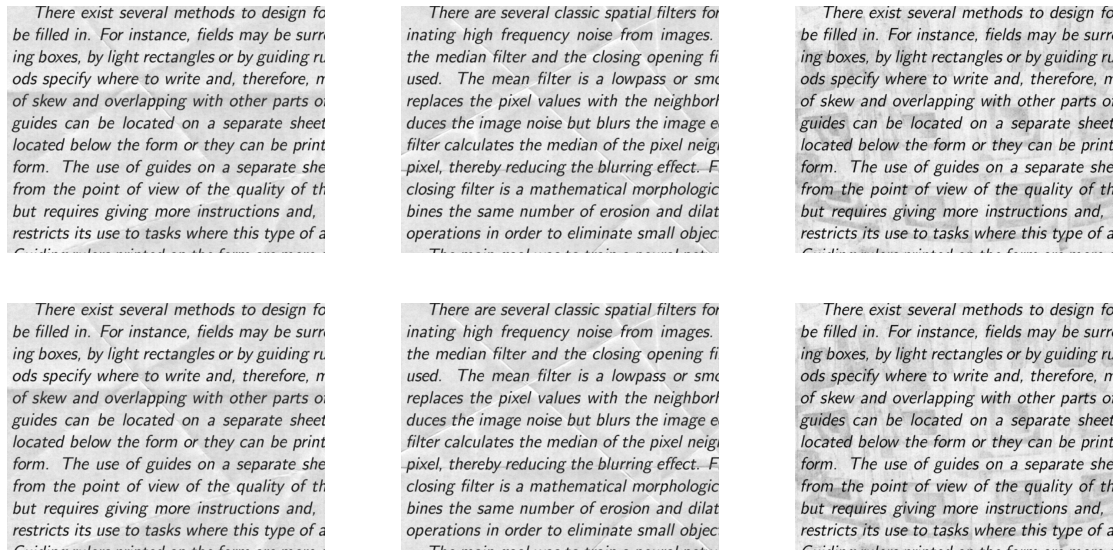

In [27]:
# The train directory comtaims png files. Let's get all the files and check a few samples
train_images = sorted(os.listdir(train))
train_labels = sorted(os.listdir(train_cleaned))
test_images = sorted(os.listdir(test))
print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))
print("Total number of samples in the test set: ", len(test_images))

# Lets' plot a few samples
# First row will be raw data, second row will be the corresponding cleaned images
samples = train_images[:3] + train_labels[:3]

f, ax = plt.subplots(2, 3, figsize=(20,10))
for i, img in enumerate(samples):
    img = imread(train/img)
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].axis('off')
plt.show()   

In [28]:
# Lets' define our autoencoder now
def build_autoenocder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #enoder 
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    #decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

In [34]:
autoencoder = build_autoenocder()
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 420, 540, 1)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 420, 540, 32)      320       
                                                                 
 pool1 (MaxPooling2D)        (None, 210, 270, 32)      0         
                                                                 
 Conv2 (Conv2D)              (None, 210, 270, 64)      18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 105, 135, 64)      0         
                                                                 
 Conv3 (Conv2D)              (None, 105, 135, 64)      36928     
                                                                 
 upsample1 (UpSampling2D)    (None, 210, 270, 64)      0     

In [29]:
X = []
Y = []

for img in train_images:
    img = load_img(train / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(train_cleaned / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)


In [30]:
# Split the dataset into training and validation. Always set the random state!!
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)


In [57]:
# Train your model
history= autoencoder.fit(X_train, y_train, epochs=300, batch_size=8, validation_data=(X_valid, y_valid))

Epoch 1/300
17/17 [==============================] - 1s 66ms/step - loss: 0.0977 - val_loss: 0.1058
Epoch 2/300
17/17 [==============================] - 1s 64ms/step - loss: 0.0975 - val_loss: 0.1058
Epoch 3/300
17/17 [==============================] - 1s 63ms/step - loss: 0.0974 - val_loss: 0.1055
Epoch 4/300
17/17 [==============================] - 1s 65ms/step - loss: 0.0974 - val_loss: 0.1054
Epoch 5/300
17/17 [==============================] - 1s 64ms/step - loss: 0.0973 - val_loss: 0.1053
Epoch 6/300
17/17 [==============================] - 1s 63ms/step - loss: 0.0973 - val_loss: 0.1053
Epoch 7/300
17/17 [==============================] - 1s 66ms/step - loss: 0.0973 - val_loss: 0.1053
Epoch 8/300
17/17 [==============================] - 1s 65ms/step - loss: 0.0972 - val_loss: 0.1056
Epoch 9/300
17/17 [==============================] - 1s 63ms/step - loss: 0.0974 - val_loss: 0.1074
Epoch 10/300
17/17 [==============================] - 1s 64ms/step - loss: 0.0977 - val_loss: 0.1058

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


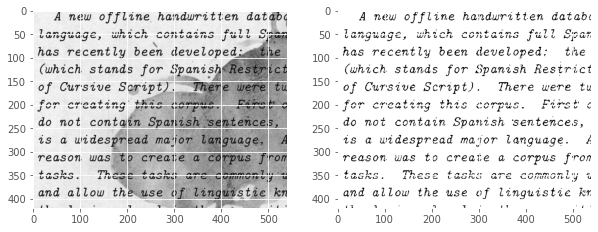

In [58]:
# Let's test our model on a sample test image
sample_test = load_img(test/ test_images[10], grayscale=True, target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()

In [64]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import cv2
import argparse

In [65]:
def options():
 parser = argparse.ArgumentParser(description="Read image metadata")
 parser.add_argument("-o", "/content/drive/MyDrive/document_denoising_dataset/testt", help="Input image file.", required=True)
 parser.add_argument("-c", "/content/drive/MyDrive/document_denoising_dataset/test", help="Input image file.", required=True)
 args = parser.parse_args()
 return args


In [70]:
def mse(imageA, imageB):
 # the 'Mean Squared Error' between the two images is the sum of the squared difference between the two images
 mse_error = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
 mse_error /= float(imageA.shape[0] * imageA.shape[1])
	
 # return the MSE. The lower the error, the more "similar" the two images are.
 return mse_error

def compare(imageA, imageB):
 # Calculate the MSE and SSIM
 m = mse(imageA, imageB)
 s = ssim(imageA, imageB)
 return s
 


In [45]:
autoencoder.save("DAE_doc_denoise.h5")

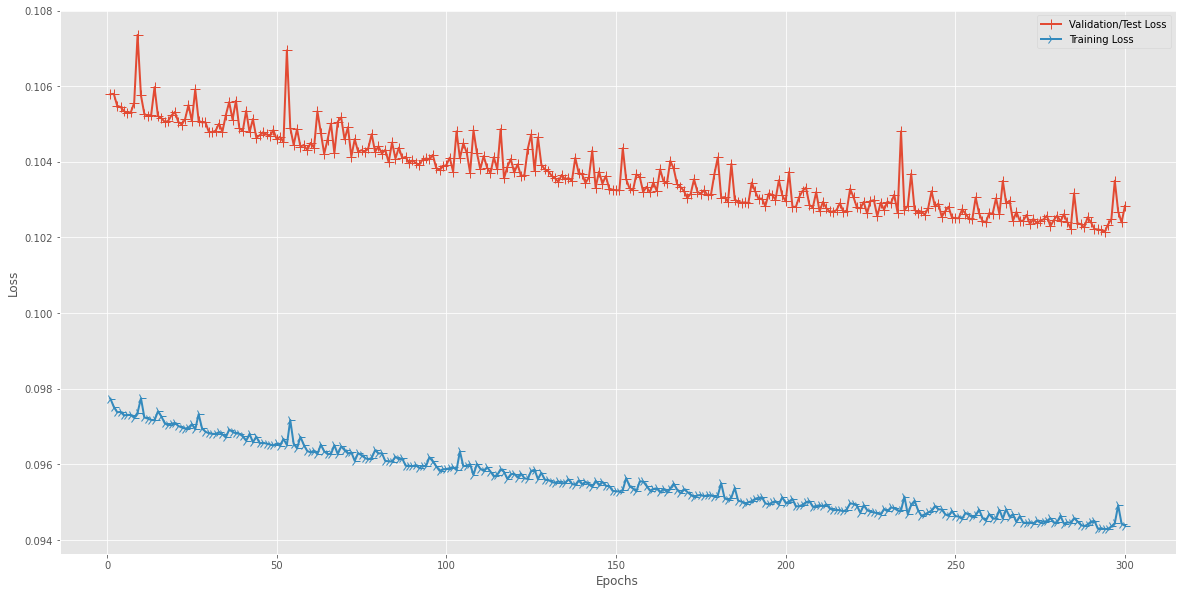

In [59]:
# print(history.history.keys())
# Plotting our loss charts
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.style.use("ggplot")

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig('Loss_DAE.png', dpi = 1200)
plt.show()

    

# MSE ands SSIM score 

In [ ]:
from skimage.measure import compare_ssim
preds=autoencoder.predict(noisy)
ssim_score= compare_ssim(preds,clean,multichannel=True)
loss_mse= autoencoder.evaluate(preds,clean)
print("CAE MSE validation loss:", loss_mse)
print("CAE SSIM score:", ssim_score)

# CAE with document diag

> Indented block



In [79]:
import numpy as np 
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,UpSampling2D,InputLayer,Reshape

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import matplotlib.pyplot as plt

#%% Data receive functions, receive datas from folders

def getData(pathd,shape):
    #file i/o çalışılmalı
    os.chdir(pathd)
    Alldatas=[]
    img_data=[]
    img_data=os.listdir(".")
    for image in img_data:
        _,extension = os.path.splitext(image)
        if(extension==".jpg" or extension==".jpeg" or extension==".png"):
            img=load_img(image)
            img=img.resize((shape[0],shape[1]))
            x=img_to_array(img)
           # x=x.reshape((1,) + x.shape)
            Alldatas.append(x)
    return Alldatas
scale=(540,258)
all_img=getData("/content/drive/MyDrive/document_denoising_dataset/train",scale)
all_img_y=getData("/content/drive/MyDrive/document_denoising_dataset/train_cleaned",scale)
#%%
all_img=tf.image.rgb_to_grayscale(all_img)
all_img_y=tf.image.rgb_to_grayscale(all_img_y)
#%%

In [ ]:

path = '/content/drive/MyDrive/document_denoising_dataset'

# unzip files first to working directory
# We could use also unzipped data source, but why not to learn something new?
with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'sampleSubmission.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  

In [ ]:
# store image names in list for later use
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

In [ ]:
# prepare function
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 1))
    
    return img

In [ ]:
# preprocess images
train = []
train_cleaned = []
test = []

for f in sorted(os.listdir(path + 'train/')):
    train.append(process_image(path + 'train/' + f))

for f in sorted(os.listdir(path + 'train_cleaned/')):
    train_cleaned.append(process_image(path + 'train_cleaned/' + f))
   
for f in sorted(os.listdir(path + 'test/')):
    test.append(process_image(path + 'test/' + f))

In [ ]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show(

In [ ]:
# convert list to numpy array
X_train = np.asarray(train)
y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)

# Creating Convolutional Autoencoder

In [ ]:
conv_autoencoder = Sequential()

# Encoder
conv_autoencoder.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(420,540,1), activation='relu', padding='same'))
conv_autoencoder.add(MaxPooling2D((2, 2), padding='same'))

conv_autoencoder.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'))
conv_autoencoder.add(MaxPooling2D((2, 2), padding='same'))



# Decoder
conv_autoencoder.add(Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'))
conv_autoencoder.add(Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'))


# Output
conv_autoencoder.add(Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same'))

conv_autoencoder.summary()

In [ ]:
conv_autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
history= conv_autoencoder.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=200, batch_size=16, callbacks= [early_stop])

In [ ]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [ ]:
y_pred = conv_autoencoder.predict(X_test, batch_size=16)

In [ ]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(y_pred[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()

In [ ]:
from skimage.measure import compare_ssim
preds=autoencoder.predict(noisy)
ssim_score= compare_ssim(preds,clean,multichannel=True)
loss_mse= autoencoder.evaluate(preds,clean)
print("CAE MSE validation loss:", loss_mse)
print("CAE SSIM score:", ssim_score)

# Deep Convolutional GANs with CIFAR10

# Load libraries

In [14]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [35]:
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from keras import initializers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras import backend as K

# Getting the data

In [22]:
# load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 6s 0us/step


# Explore visual data

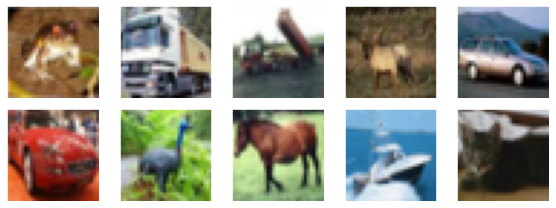

In [23]:
fig = plt.figure(figsize=(8,3))
for i in range(0, 10):
    plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(X_train[i])
    
plt.tight_layout()

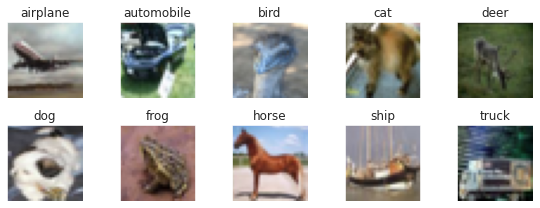

In [24]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

# Reshaping and normalizing the inputs

In [25]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [37]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# convert class vectors to binary class matrices
Y_train = utils.to_categorical(y_train, num_classes)
Y_test = utils.to_categorical(y_test, num_classes)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_train / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)

X_train reshape: (50000, 32, 32, 3)
X_test reshape: (50000, 32, 32, 3)


# 2. Define model

In [38]:
# latent space dimension
latent_dim = 100

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# FC: 2x2x512
generator.add(Dense(2*2*512, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(Reshape((2, 2, 512)))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# # Conv 1: 4x4x256
generator.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 2: 8x8x128
generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 3: 16x16x64
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 4: 32x32x3
generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same',
                              activation='tanh'))

In [39]:
# prints a summary representation of your model
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              206848    
                                                                 
 reshape (Reshape)           (None, 2, 2, 512)         0         
                                                                 
 batch_normalization (BatchN  (None, 2, 2, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        3277056   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 4, 4, 256)        1

# Discriminator

In [40]:
# imagem shape 32x32x3
img_shape = X_train[0].shape

# Discriminator network
discriminator = Sequential()

# Conv 1: 16x16x64
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same',
                         input_shape=(img_shape), kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# FC
discriminator.add(Flatten())

# Output
discriminator.add(Dense(1, activation='sigmoid'))

# Discriminator model visualizatio

In [41]:
# prints a summary representation of your model
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         819456    
                                                      

# 3. Compile model
# Compile discriminator

In [42]:
# Optimizer

discriminator.compile(Adam(lr=0.0003, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Combined network
### We connect the generator and the discriminator to make a DCGAN.

In [43]:
# d_g = discriminador(generador(z))
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

d_g.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# GAN model vizualization

In [44]:
# prints a summary representation of your model
d_g.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         4516739   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 4312193   
                                                                 
Total params: 8,828,932
Trainable params: 4,514,819
Non-trainable params: 4,314,113
_________________________________________________________________


# 4. Fit model

epoch = 1/100, d_loss=0.163, g_loss=0.228                                                                                                     


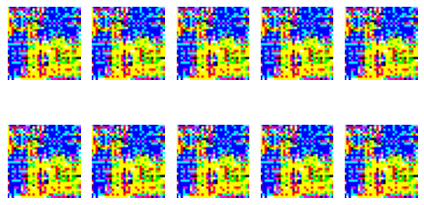

epoch = 2/100, d_loss=0.163, g_loss=0.214                                                                                                     
epoch = 3/100, d_loss=0.163, g_loss=0.216                                                                                                     
epoch = 4/100, d_loss=0.163, g_loss=0.217                                                                                                     
epoch = 5/100, d_loss=0.163, g_loss=0.230                                                                                                     
epoch = 6/100, d_loss=0.163, g_loss=0.216                                                                                                     
epoch = 7/100, d_loss=0.163, g_loss=0.220                                                                                                     
epoch = 8/100, d_loss=0.163, g_loss=0.221                                                                                                     

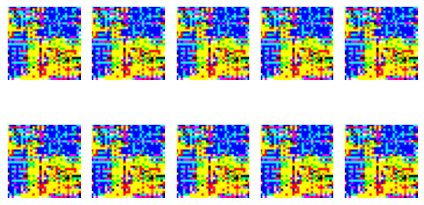

epoch = 12/100, d_loss=0.163, g_loss=0.222                                                                                                     
epoch = 13/100, d_loss=0.163, g_loss=0.223                                                                                                     
epoch = 14/100, d_loss=0.163, g_loss=0.217                                                                                                     
epoch = 15/100, d_loss=0.163, g_loss=0.218                                                                                                     
epoch = 16/100, d_loss=0.163, g_loss=0.219                                                                                                     
epoch = 17/100, d_loss=0.163, g_loss=0.220                                                                                                     
epoch = 18/100, d_loss=0.163, g_loss=0.219                                                                                              

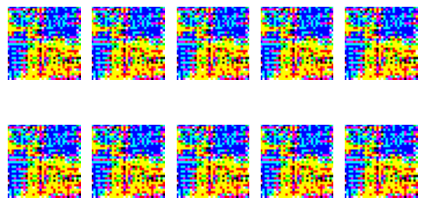

epoch = 22/100, d_loss=0.163, g_loss=0.216                                                                                                     
epoch = 23/100, d_loss=0.163, g_loss=0.215                                                                                                     
epoch = 24/100, d_loss=0.163, g_loss=0.214                                                                                                     
epoch = 25/100, d_loss=0.163, g_loss=0.221                                                                                                     
epoch = 26/100, d_loss=0.163, g_loss=0.221                                                                                                     
epoch = 27/100, d_loss=0.163, g_loss=0.220                                                                                                     
epoch = 28/100, d_loss=0.163, g_loss=0.212                                                                                              

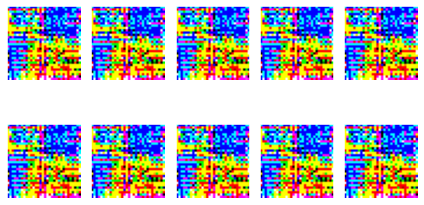

epoch = 32/100, d_loss=0.163, g_loss=0.215                                                                                                     
epoch = 33/100, d_loss=0.163, g_loss=0.216                                                                                                     
epoch = 34/100, d_loss=0.163, g_loss=0.214                                                                                                     
epoch = 35/100, d_loss=0.163, g_loss=0.212                                                                                                     
epoch = 36/100, d_loss=0.163, g_loss=0.210                                                                                                     
epoch = 37/100, d_loss=0.163, g_loss=0.209                                                                                                     
epoch = 38/100, d_loss=0.163, g_loss=0.212                                                                                              

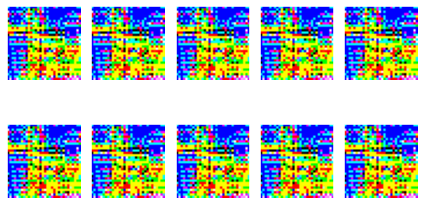

epoch = 42/100, d_loss=0.163, g_loss=0.207                                                                                                     
epoch = 43/100, d_loss=0.163, g_loss=0.211                                                                                                     
epoch = 44/100, d_loss=0.163, g_loss=0.205                                                                                                     
epoch = 45/100, d_loss=0.163, g_loss=0.204                                                                                                     
epoch = 46/100, d_loss=0.163, g_loss=0.210                                                                                                     
epoch = 47/100, d_loss=0.163, g_loss=0.206                                                                                                     
epoch = 48/100, d_loss=0.163, g_loss=0.207                                                                                              

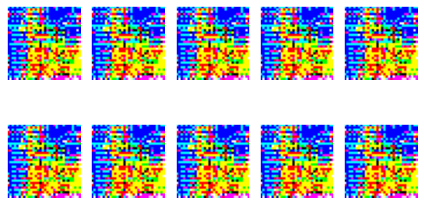

epoch = 52/100, d_loss=0.163, g_loss=0.203                                                                                                     
epoch = 53/100, d_loss=0.163, g_loss=0.203                                                                                                     
epoch = 54/100, d_loss=0.163, g_loss=0.203                                                                                                     
epoch = 55/100, d_loss=0.163, g_loss=0.205                                                                                                     
epoch = 56/100, d_loss=0.163, g_loss=0.197                                                                                                     
epoch = 57/100, d_loss=0.163, g_loss=0.195                                                                                                     
epoch = 58/100, d_loss=0.163, g_loss=0.191                                                                                              

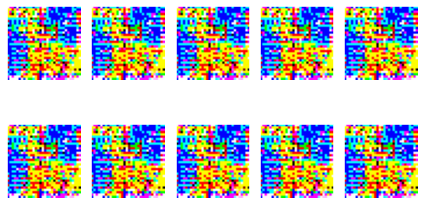

epoch = 62/100, d_loss=0.163, g_loss=0.191                                                                                                     
epoch = 63/100, d_loss=0.163, g_loss=0.189                                                                                                     
epoch = 64/100, d_loss=0.163, g_loss=0.187                                                                                                     
epoch = 65/100, d_loss=0.163, g_loss=0.183                                                                                                     
epoch = 66/100, d_loss=0.163, g_loss=0.184                                                                                                     
epoch = 67/100, d_loss=0.163, g_loss=0.182                                                                                                     
epoch = 68/100, d_loss=0.163, g_loss=0.182                                                                                              

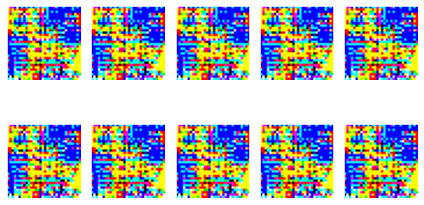

epoch = 72/100, d_loss=0.163, g_loss=0.182                                                                                                     
epoch = 73/100, d_loss=0.163, g_loss=0.180                                                                                                     
epoch = 74/100, d_loss=0.163, g_loss=0.179                                                                                                     
epoch = 75/100, d_loss=0.163, g_loss=0.180                                                                                                     
epoch = 76/100, d_loss=0.163, g_loss=0.182                                                                                                     
epoch = 77/100, d_loss=0.163, g_loss=0.181                                                                                                     
epoch = 78/100, d_loss=0.163, g_loss=0.179                                                                                              

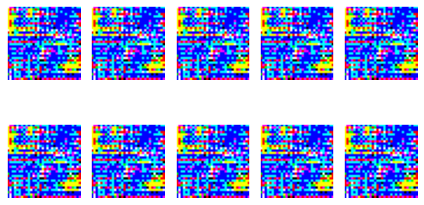

epoch = 82/100, d_loss=0.163, g_loss=0.183                                                                                                     
epoch = 83/100, d_loss=0.163, g_loss=0.180                                                                                                     
epoch = 84/100, d_loss=0.163, g_loss=0.182                                                                                                     
epoch = 85/100, d_loss=0.163, g_loss=0.181                                                                                                     
epoch = 86/100, d_loss=0.163, g_loss=0.177                                                                                                     
epoch = 87/100, d_loss=0.163, g_loss=0.178                                                                                                     
epoch = 88/100, d_loss=0.163, g_loss=0.179                                                                                              

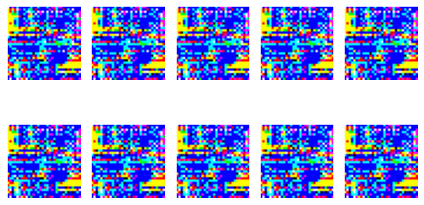

epoch = 92/100, d_loss=0.163, g_loss=0.180                                                                                                     
epoch = 93/100, d_loss=0.163, g_loss=0.180                                                                                                     
epoch = 94/100, d_loss=0.163, g_loss=0.182                                                                                                     
epoch = 95/100, d_loss=0.163, g_loss=0.178                                                                                                     
epoch = 96/100, d_loss=0.163, g_loss=0.176                                                                                                     
epoch = 97/100, d_loss=0.163, g_loss=0.180                                                                                                     
epoch = 98/100, d_loss=0.163, g_loss=0.178                                                                                              

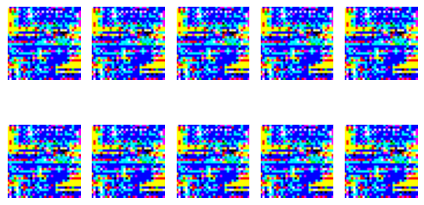

In [47]:
epochs = 100
batch_size = 32
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch,
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

        plt.tight_layout()
        plt.show()

# 5. Evaluate model

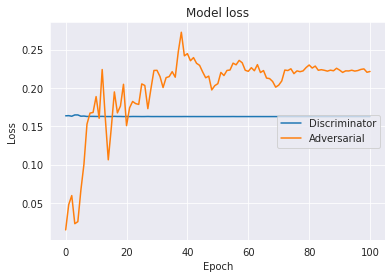

In [46]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

# CIFAR 10 VAE

In [1]:
# importing all the required libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torch.distributions 

from PIL import Image
import torchvision.utils
import numpy as np
import matplotlib.pyplot as plt

# checking for device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10_Data/cifar-10-python.tar.gz to CIFAR10_Data
Files already downloaded and verified
torch.Size([100, 3, 32, 32])
<class 'torchvision.datasets.cifar.CIFAR10'>


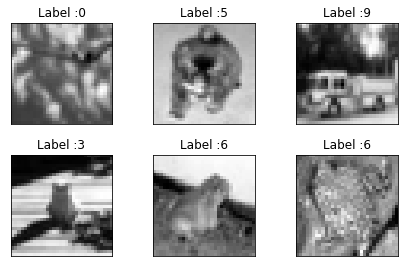

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

#downloading mnist dataset
train_data = CIFAR10('CIFAR10_Data', download = True,train = True, transform = transform) 
test_data =CIFAR10('CIFAR10_Data', download = True, train= False, transform = transform)

#Loading the data in data loader
BATCH_SIZE = 100
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE ,shuffle= True)
test_dataloader = DataLoader(test_data, batch_size= BATCH_SIZE, shuffle = True)

# showing some of the data samples
examples = enumerate(train_dataloader)
batch_idx, (example_data, example_targets) = next(examples)

print(example_data.shape)
print(type(train_data))
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title('Label :' + str(int(example_targets[i])))
  plt.xticks([])
  plt.yticks([])
fig.show()

In [3]:
# class for encoder
class EncoderModule(nn.Module):
    def __init__(self, input_channels, output_channels, stride, kernel, pad):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=kernel, padding=pad, stride=stride)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class Encoder(nn.Module):
    def __init__(self, color_channels, pooling_kernels, n_neurons_in_middle_layer):
        self.n_neurons_in_middle_layer = n_neurons_in_middle_layer
        super().__init__()
        self.bottle = EncoderModule(color_channels, 32, stride=1, kernel=1, pad=0)
        self.m1 = EncoderModule(32, 64, stride=1, kernel=3, pad=1)
        self.m2 = EncoderModule(64, 128, stride=pooling_kernels[0], kernel=3, pad=1)
        self.m3 = EncoderModule(128, 256, stride=pooling_kernels[1], kernel=3, pad=1)

    def forward(self, x):
        out = self.m3(self.m2(self.m1(self.bottle(x))))
        return out.view(-1, self.n_neurons_in_middle_layer)


#class for decoder
class DecoderModule(nn.Module):
    def __init__(self, input_channels, output_channels, stride, activation="relu"):
        super().__init__()
        self.convt = nn.ConvTranspose2d(input_channels, output_channels, kernel_size=stride, stride=stride)
        self.bn = nn.BatchNorm2d(output_channels)
        if activation == "relu":
            self.activation = nn.ReLU(inplace=True)
        elif activation == "sigmoid":
            self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.bn(self.convt(x)))

class Decoder(nn.Module):
    def __init__(self, color_channels, pooling_kernels, decoder_input_size):
        self.decoder_input_size = decoder_input_size
        super().__init__()
        self.m1 = DecoderModule(256, 128, stride=1)
        self.m2 = DecoderModule(128, 64, stride=pooling_kernels[1])
        self.m3 = DecoderModule(64, 32, stride=pooling_kernels[0])
        self.bottle = DecoderModule(32, color_channels, stride=1, activation="sigmoid")

    def forward(self, x):
        out = x.view(-1, 256, self.decoder_input_size, self.decoder_input_size)
        out = self.m3(self.m2(self.m1(out)))
        return self.bottle(out)

In [4]:
# class for VAE
class VAE(nn.Module):
    def __init__(self,latent ,kernel,encoder_out_size, channels):
        super().__init__()
        self.n_latent_features = latent
        pooling_kernel = kernel
        encoder_output_size = encoder_out_size
        color_channels = channels

        n_neurons_middle_layer = 256 * encoder_output_size * encoder_output_size

        # Encoder
        self.encoder = Encoder(color_channels, pooling_kernel, n_neurons_middle_layer)
        # Middle
        self.fc1 = nn.Linear(n_neurons_middle_layer, self.n_latent_features)
        self.fc2 = nn.Linear(n_neurons_middle_layer, self.n_latent_features)
        self.fc3 = nn.Linear(self.n_latent_features, n_neurons_middle_layer)
        # Decoder
        self.decoder = Decoder(color_channels, pooling_kernel, encoder_output_size)

    def _reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def _bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self._reparameterize(mu, logvar)
        return z, mu, logvar
        
    def sampling(self):
        z = torch.randn(64, self.n_latent_features).to(device)
        z = self.fc3(z)
       
        return self.decoder(z)

    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self._bottleneck(h)
        z = self.fc3(z)
        d = self.decoder(z)
        return d, mu, logvar

In [5]:
#Training VAE

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)        
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

latent_size = 64
kernel = [4,2]
encoder_out = 4
channels = 3
vae = VAE(latent_size, kernel, encoder_out, channels).to(device)



epochs = 25
learning_rate = 0.001
optimizer = torch.optim.Adam(vae.parameters(), lr = learning_rate)

losses = []
for epoch in range(epochs):
    for batch_idx, (inputs, _) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = vae(inputs)

        loss = loss_function(recon_batch, inputs, mu, logvar)
        loss.backward()
        optimizer.step()


    losses.append(loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


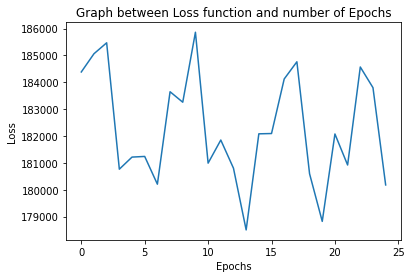

In [6]:
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Graph between Loss function and number of Epochs")
plt.plot(losses)
plt.show()

In [7]:
# saving model
PATH = 'saved_VAE_model.pth'
torch.save(vae, PATH)

In [8]:
PATH = 'saved_VAE_model.pth'
#loading the model
vae_model = torch.load(PATH)

In [9]:
from torchvision.utils import save_image

vae.eval()
val_loss = 0
samples_cnt = 0
for epoch in range(epochs):
    with torch.no_grad():
        for batch_idx, (inputs, _) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            recon_batch, mu, logvar = vae(inputs)
            val_loss += loss_function(recon_batch, inputs, mu, logvar).item()
            samples_cnt += inputs.size(0)

            if batch_idx == 0:
                save_image(recon_batch, f"{'VAE'}.png", nrow=8)

        print(batch_idx, len(test_dataloader), f"ValLoss: {val_loss/samples_cnt:f}")

    save_image(vae.sampling(), f"{'VAE'}{str(epoch)}.png", nrow=8)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


99 100 ValLoss: 1821.395494
99 100 ValLoss: 1821.397498
99 100 ValLoss: 1821.429866
99 100 ValLoss: 1821.407515
99 100 ValLoss: 1821.395996
99 100 ValLoss: 1821.404511
99 100 ValLoss: 1821.409423
99 100 ValLoss: 1821.405323
99 100 ValLoss: 1821.407449
99 100 ValLoss: 1821.399182
99 100 ValLoss: 1821.400882
99 100 ValLoss: 1821.410979
99 100 ValLoss: 1821.409954
99 100 ValLoss: 1821.409950
99 100 ValLoss: 1821.412993
99 100 ValLoss: 1821.415421
99 100 ValLoss: 1821.414635
99 100 ValLoss: 1821.414580
99 100 ValLoss: 1821.414116
99 100 ValLoss: 1821.414958
99 100 ValLoss: 1821.413447
99 100 ValLoss: 1821.412929
99 100 ValLoss: 1821.406150
99 100 ValLoss: 1821.403905
99 100 ValLoss: 1821.405213


# Document denosing with AE

In [6]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l1,l1_l2,l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D,MaxPool2D,UpSampling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import he_uniform,he_normal
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from shutil import copy2
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import VotingClassifier
import cv2
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from collections import Counter
import numpy as np
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.models import load_model
# from vis.utils import utils
from tensorflow.keras import activations 
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from tqdm import tqdm

# 1. Dataset Preparation

In [12]:
# num_classes = 15
# img_rows, img_cols = 224,224
img_shape=224,224
batch_size =16
rescale=1./255
# home/kashraf/fall2021_cours
train_data_dir ="/content/drive/MyDrive/document_denoising_dataset/train"
validation_data_dir = "/content/drive/MyDrive/document_denoising_dataset/train_cleaned"

train_names=os.listdir(train_data_dir)
test_names=os.listdir(validation_data_dir)

train=[]
test=[]
for file in train_names:
    img=cv2.imread(train_data_dir+file)
    img=cv2.resize(img,img_shape)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    train.append(img)
for file in test_names:
    img=cv2.imread(validation_data_dir+file)
    img=cv2.resize(img, img_shape)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    test.append(img)
x_train=np.array(train)
x_test=np.array(test)

error: ignored

In [2]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l1,l1_l2,l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D,MaxPool2D,UpSampling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import he_uniform,he_normal
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from shutil import copy2
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import VotingClassifier
import cv2
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from collections import Counter
import numpy as np
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.models import load_model
# from vis.utils import utils
from tensorflow.keras import activations 
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from tqdm import tqdm

In [20]:
# num_classes = 15
# img_rows, img_cols = 224,224
img_shape=56,56
batch_size =16
rescale=1./255
# home/kashraf/fall2021_cours
train_data_dir ="/content/drive/MyDrive/document_denoising_dataset/train"
validation_data_dir = "/content/drive/MyDrive/document_denoising_dataset/train_cleaned"
train_names=os.listdir(train_data_dir)
test_names=os.listdir(validation_data_dir)

In [24]:
train=[]
test=[]
for file in train_names:
    img=cv2.imread(train_data_dir+file)
    img=cv2.resize(img, img_shape)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    train.append(img)
    
for file in test_names:
    img=cv2.imread(validation_data_dir+file)
    img=cv2.resize(img, img_shape)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    test.append(img)
x_train=np.array(train)
x_test=np.array(test)

error: ignored

# VAE CIFAR10

In [17]:
import os
import logging
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
from tqdm import tqdm
!pip install alibi-detect
from alibi_detect.models.tensorflow.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score
from alibi_detect.utils.visualize import plot_feature_outlier_im

ImportError: ignored

In [3]:
train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

170508288/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


# Load or define outlier detector

In [18]:
load_outlier_detector = True

In [19]:
filepath = 'my_path'  # change to directory where model is downloaded
detector_type = 'outlier'
dataset = 'cifar10'
detector_name = 'OutlierVAE'
filepath = os.path.join(filepath, detector_name)
if load_outlier_detector:  # load pretrained outlier detector
    od = fetch_detector(filepath, detector_type, dataset, detector_name)
else:  # define model, initialize, train and save outlier detector
    latent_dim = 1024

    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(32, 32, 3)),
          Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
      ])

    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(4*4*128),
          Reshape(target_shape=(4, 4, 128)),
          Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
      ])

    # initialize outlier detector
    od = OutlierVAE(threshold=.015,  # threshold for outlier score
                    score_type='mse',  # use MSE of reconstruction error for outlier detection
                    encoder_net=encoder_net,  # can also pass VAE model instead
                    decoder_net=decoder_net,  # of separate encoder and decoder
                    latent_dim=latent_dim,
                    samples=2)
    # train
    od.fit(X_train,
           loss_fn=elbo,
           cov_elbo=dict(sim=.05),
           epochs=50,
           verbose=False)

    # save the trained outlier detector
    save_detector(od, filepath)

/usr/local/lib/python3.7/dist-packages/alibi_detect/utils/saving.py:979: UserWarning:

Trying to load detector from an older version.This may lead to breaking code or invalid results.




Two checkpoint references resolved to different objects (<keras.layers.convolutional.Conv2D object at 0x7f5f94a8bd90> and <keras.layers.convolutional.Conv2D object at 0x7f5f94aa5e10>).

Two checkpoint references resolved to different objects (<keras.layers.convolutional.Conv2D object at 0x7f5f94aa5e10> and <keras.layers.convolutional.Conv2D object at 0x7f5f94a96a90>).

Two checkpoint references resolved to different objects (<keras.layers.core.dense.Dense object at 0x7f5f94aa7f10> and <keras.layers.core.reshape.Reshape object at 0x7f5f94ab1e10>).

Two checkpoint references resolved to different objects (<keras.layers.convolutional.Conv2DTranspose object at 0x7f5f94a3a550> and <keras.layers.convolutional.Conv2DTranspose object at 0x7f5f94a40550>).

Two checkpoint references resolved to different objects (<keras.layers.convolutional.Conv2DTranspose object at 0x7f5f94a40550> and <keras.layers.convolutional.Conv2DTranspose object at 0x7f5f94a45e50>).


# Check quality VAE model


In [20]:
from sklearn.model_selection import train_test_split

In [ ]:
idx = 8

X = X_train[idx].reshape(1, 32, 32, 3)
X_recon = od.vae(X)

In [ ]:
plt.imshow(X.reshape(32, 32, 3))
plt.axis('off')
plt.show()

# task 2 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

In [2]:
# Load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

170508288/170498071 [==============================] - 3s 0us/step
Train (50000, 32, 32, 3) (50000, 1)
Test (10000, 32, 32, 3) (10000, 1)


In [3]:
# example of a dcgan on cifar10
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot

In [4]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [50]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
#return model

In [43]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [51]:
# load and prepare cifar10 training images
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

In [52]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

In [53]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [54]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [55]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

In [56]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

In [57]:
# Loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0)).numpy()

In [58]:
def train_mine(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=2,n_batch=256):
  bat_per_epo = int(dataset.shape[0]/n_batch)
  half_batch = int(n_batch/2)
  mseLoss = 0.0
  ssimLoss = 0.0
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      X_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      difference_array = np.subtract(X_real, X_fake)
      squared_array = np.square(difference_array)
      mseLoss = squared_array.mean()
      #mseLoss = mse(X_real, X_gan).numpy()
      ssimLoss = ssim_loss(X_real,X_fake)
      if (i+1) % 10 == 0:
        summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [63]:
# size of the latent space
latent_dim = 100
epoches= 100
batch_size = 2048
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
#gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
#train_mine(g_model, d_model, gan_model, dataset, latent_dim,epoches,batch_size)

In [67]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# plot the generated images
def create_plot(examples, n):
	# plot images
	#pyplot.figure(figsize=(10,10))
	for i in range(n*n):
		# define subplot
		pyplot.figure(figsize=(10,10))
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
		pyplot.savefig("gen_horse.png")
	pyplot.show()

# load model
model = load_model('generator_model_200.h5')
# generate images
latent_points = generate_latent_points(100, 144)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 5)

OSError: ignored

# Variational Auto-encoder

In [68]:
## load the libraries 
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import Adam, RMSprop
from scipy.stats import norm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import datasets

from tensorflow.keras import backend as K
K.clear_session()
from imgaug import augmenters
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

plt.gray()

<Figure size 432x288 with 0 Axes>

In [70]:
from google.colab import drive
#drive.mount( '/content/drive', force_remount=True )
PATH ="/content/drive/MyDrive/document_denoising_dataset"

In [71]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

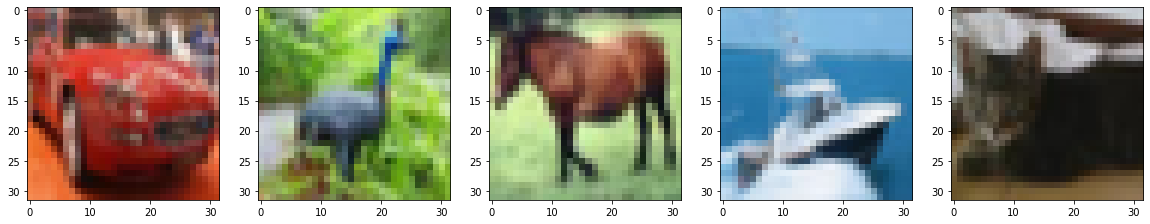

In [72]:
f, ax = plt.subplots(1,5)
f.set_size_inches(20, 20)
for i in range(5,10):
    ax[i-5].imshow(x_train[i])

# Part 2: Denoise Images using AEs
# Design the network

In [73]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [74]:
from torchvision.datasets.utils import download_url
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [75]:
# Extract from archive
import tarfile
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall()

In [76]:
!tar -xzvf "cifar-10-python.tar.gz" -C "/content/drive/MyDrive/NeuralNetworkAssignmentFall2021/assignment5/"

tar (child): cifar-10-python.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [77]:
!unzip "/content/drive/MyDrive/NeuralNetworkAssignmentFall2021/assignment5/cifar10/data_batch_1.zip" -d "/content/drive/MyDrive/NeuralNetworkAssignmentFall2021/assignment5/cifar10/train/"

unzip:  cannot find or open /content/drive/MyDrive/NeuralNetworkAssignmentFall2021/assignment5/cifar10/data_batch_1.zip, /content/drive/MyDrive/NeuralNetworkAssignmentFall2021/assignment5/cifar10/data_batch_1.zip.zip or /content/drive/MyDrive/NeuralNetworkAssignmentFall2021/assignment5/cifar10/data_batch_1.zip.ZIP.


In [78]:
# prints : Total number of images : 202599
INPUT_DIM = (32,32,3) # Image dimension
BATCH_SIZE = 512
Z_DIM = 200 # Dimension of the latent vector (z)

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory('cifar10/train/', 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training'
                                                                   )

Found 50000 images belonging to 10 classes.


In [79]:
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides, use_batch_norm = False, use_dropout = False):
  
  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model 
  # would be inconsistent
  global K
  K.clear_session()
  
  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)
      if use_batch_norm:
        x = BathcNormalization()(x)
  
      x = LeakyReLU()(x)

      if use_dropout:
        x = Dropout(rate=0.25)(x)

  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = K.int_shape(x)[1:] 
  
  x = Flatten()(x)
  
  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon   
  
  # Using a Keras Lambda Layer to include the sampling function as a layer 
  # in the model
  encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])

  return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)

vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

In [80]:
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

  # To get an exact mirror image of the encoder
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)
      
      # Adding a sigmoid layer at the end to restrict the outputs 
      # between 0 and 1
      if i < n_layers - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)

  # Define model output
  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)

decoder_input, decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = vae_shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )

In [81]:
# The input to the model will be the image fed to the encoder.
vae_input = vae_encoder_input

# Output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
vae_model = Model(vae_input, vae_output)

In [82]:
LEARNING_RATE = 0.0005
N_EPOCHS = 100
LOSS_FACTOR = 10000
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])
def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)
  
adam_optimizer = Adam(learning_rate = LEARNING_RATE)

vae_model.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

#checkpoint_vae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/weights.h5'), save_weights_only = True, verbose=1)

history = vae_model.fit(data_flow, 
                        shuffle=True, 
                        epochs = N_EPOCHS, 
                        initial_epoch = 0, 
                        steps_per_epoch=50000 / BATCH_SIZE,
                        callbacks=[])

Epoch 1/100
97/97 [==============================] - 60s 594ms/step - batch: 48.5000 - size: 510.2041 - loss: 518.6273 - r_loss: 0.0507 - kl_loss: 11.9639
Epoch 2/100
97/97 [==============================] - 58s 596ms/step - batch: 48.5000 - size: 510.2041 - loss: 330.7032 - r_loss: 0.0300 - kl_loss: 30.3352
Epoch 3/100
97/97 [==============================] - 59s 598ms/step - batch: 48.5000 - size: 510.2041 - loss: 302.8157 - r_loss: 0.0268 - kl_loss: 34.8966
Epoch 4/100
97/97 [==============================] - 59s 599ms/step - batch: 48.5000 - size: 510.2041 - loss: 286.0926 - r_loss: 0.0248 - kl_loss: 37.6522
Epoch 5/100
97/97 [==============================] - 59s 601ms/step - batch: 48.5000 - size: 510.2041 - loss: 273.0619 - r_loss: 0.0235 - kl_loss: 37.7309
Epoch 6/100
97/97 [==============================] - 59s 600ms/step - batch: 48.5000 - size: 510.2041 - loss: 260.7815 - r_loss: 0.0224 - kl_loss: 36.6336
Epoch 7/100
97/97 [==============================] - 61s 627ms/step - 

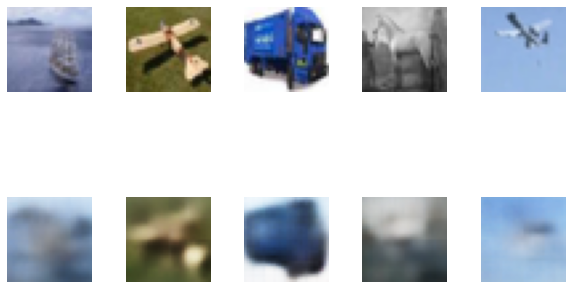

In [84]:
import matplotlib.pyplot as plt
example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:5]

def plot_compare_vae(images=None):
  
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:1]

  n_to_show = images.shape[0]
  reconst_images = vae_model.predict(images)

  fig = plt.figure(figsize=(10, 6))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off') 
      imgFileName = "/content/cifar10"+str(i)+".png"
      sub.figure.savefig(imgFileName)       
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      imgFileName = "/content/cifar10"+str(i)+".png"
      sub.figure.savefig(imgFileName) 
      sub.imshow(img)  

plot_compare_vae(images = example_images)    

In [88]:
import matplotlib.pyplot as plt
example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:5]

def plot_compare_vae(images=None):
  
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:1]

  n_to_show = images.shape[0]
  reconst_images = vae_model.predict(images)
  fig = plt.figure(figsize=(3, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)
  img = images[0].squeeze()
  sub = fig.add_subplot(2, 1, 1)
  sub.axis('off')
  
  imgFileName = "/content/cifar10"+str(0)+".png"
  sub.figure.savefig(imgFileName)
  sub.imshow(img)  

  fig = plt.figure(figsize=(3, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)
  img = reconst_images[0].squeeze()
  sub = fig.add_subplot(2, 1, 1)
  sub.axis('off')
  #sub.imshow(img)
  imgFileName = "/content/cifar10"+str(0)+".png"
  sub.figure.savefig(imgFileName)
  sub.imshow(img) 

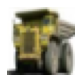

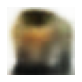

In [89]:
plot_compare_vae(images = example_images) 

dict_keys(['loss', 'r_loss', 'kl_loss'])


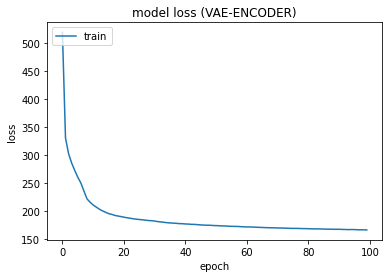

In [95]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss (VAE-ENCODER)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['loss', 'r_loss', 'kl_loss'])


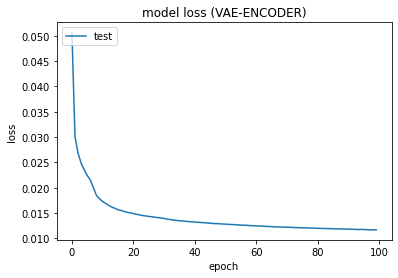

In [96]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['r_loss'])
plt.title('model loss (VAE-ENCODER)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['test'], loc='upper left')
plt.show()

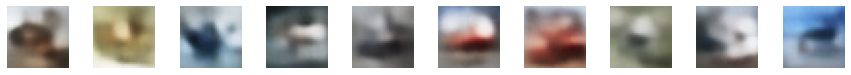

In [92]:
def vae_generate_images(n_to_show=10):
  reconst_images = vae_decoder.predict(np.random.normal(0,1,size=(n_to_show,Z_DIM)))

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img)

vae_generate_images(n_to_show=10)  

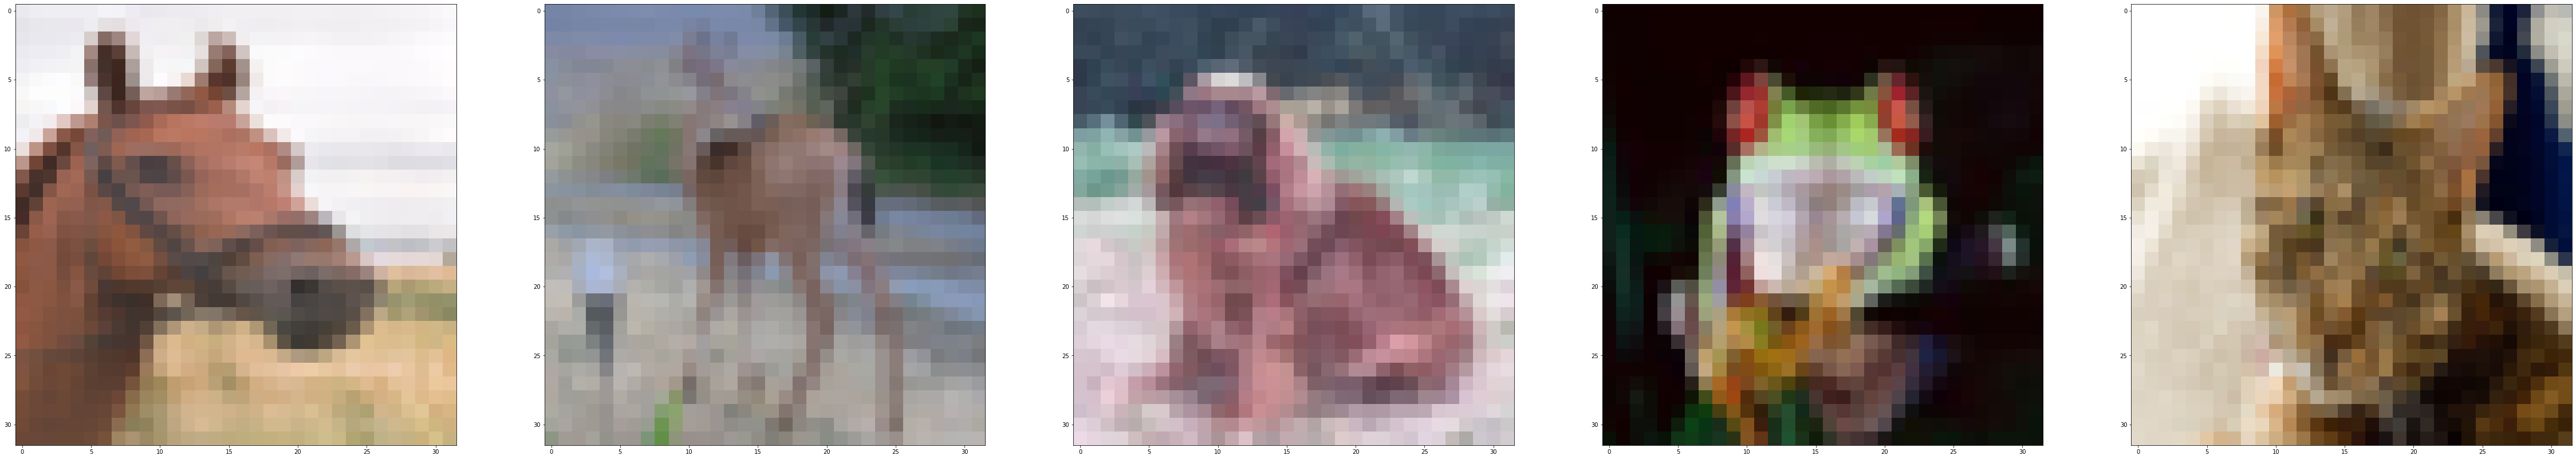

In [94]:
n = np.random.randint(0,1000)

f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(x_test[a])

In [ ]:
from skimage.measure import compare_ssim
preds=vae.predict(noisy)
ssim_score= compare_ssim(preds,clean,multichannel=True)
loss_mse= vae.evaluate(preds,clean)
print("vae MSE validation loss:", loss_mse)
print("vae SSIM score:", ssim_score)